#READ ME

This notebook shows how to:
* Find the original SPI data
* Load the us_prisoners package 
* Transform the original SPI data into the Inmates with Violent Crimes dataset using the US prisoners package
* Assess the Inmate with Violent Crimes data for bias using the aif360 toolkit
* Create custom sklearn scorers using aif360 metrics
* Score for accuracy and fairness metrics across various model hyperperameters with five fold cv using sklearn GridSearch and Pipeline
* Load the automl package
* Fit a automl estimator to the Violen Crimes Dataset
* Inspect a decision tree diagram 


Source code for the us_prisoners package is publicly available on Github, but this notebook is a convenient way of demonstrating the package's capabilities. The processing applied in this notebook aligns to that described in the Inmates with Violent Crimes Datasheet and Inmates with Violent Crimes: a New Dataset for Machine Learning Practitioners paper. If the perameters are adjusted, or if the variable configuration file is updated, the dataset amnd results will vary from what is discussed in the aforementioned documents.  ,  and inspect a digram of the tree, search using automl. 


# 1.Find the original SPI data and upload it 
In order to transform the raw US Prisoners 2016 survey data into the transformed dataset, you will need to download it; distribution rights are unclear. 

1. Go the the following webpage and however over the 'Download' button on the left hand side (as in screenshot below). Select 'Documentation Only'
2. A folder named 'ICPSR_37692-V4' will be downloaded
3. Within this file, open file 'DSOO1'
'37692-0001-Data.tsv' is the state and federal combined. 
4. Please upload this file into the Google colab runtime. This will take 5- 15 minutes due to the size of the file. 
5. Run the cell with the comment #read in raw data
6. You can then run the cell that passes the raw data to the prep function from the us prisoners package. This will return a dataset with derived, encoded and scaled features ready for use with machine learning toolkits. 

#Jump to working with the processed data without transforming the raw data
For assesment purposes, a .pkl file of the processed subset produced using the code is provided in the submission package.
To jump to working with the processed subset
1. Upload the file into the runtime
Run cell with the comment #read in processed subset in the section 'Work 2. with the violent subset'

You can then continue to run the cells for bias assessment and model training. 

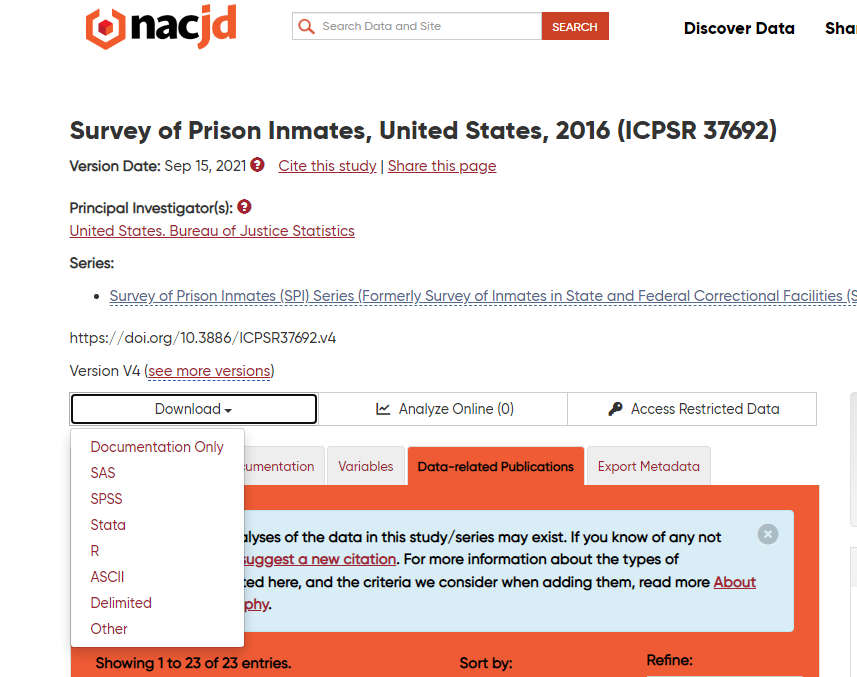

# 2.Load the US prisoners and aif360 packages

In [1]:
#clone the us prisoners package from github
!rm -r us_prisoners
!git clone https://github.com/sdurcan/us_prisoners.git

rm: cannot remove 'us_prisoners': No such file or directory
Cloning into 'us_prisoners'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 320 (delta 157), reused 263 (delta 100), pack-reused 0
Receiving objects: 100% (320/320), 2.57 MiB | 5.48 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [2]:
! pip install aif360
! pip install BlackBoxAuditing
! pip install fairlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 14.1 MB/s 
     |████████████████████████████████| 25.9 MB 1.3 MB/s 
     |████████████████████████████████| 569 kB 68.5 MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=427b02b05d70db67c26be33f80058e9befde84a21926c7a0590d7a22b056e8a9
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.5.4 which is incompatible.
Lo

In [8]:
'''Imports and set working directory'''
import os
print(os.getcwd())
os.chdir('/content/us_prisoners')
print(os.getcwd())
import src.load as load
from src import prep as prep
import src.dataset_processor as dataset_processor
import copy
from src import prep as prep
import pandas as pd
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import tree
import BlackBoxAuditing
import fairlearn
from aif360.sklearn import metrics
from sklearn.metrics import classification_report
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.sklearn.metrics import make_scorer as make_aif_scorer
from sklearn.metrics import make_scorer, accuracy_score, f1_score, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.width', 1000)
import matplotlib.font_manager
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams.update({'font.size': 14})
from sklearn import tree

/content/us_prisoners
/content/us_prisoners


In [41]:
#mount google drive for saving results
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3.Use the US Prisoners Package to create the Inmates with Violent Crimes subset

In [9]:
#if data file in DOOO1 is uploaded to the runtime
#running the below will import
#change code if mounting google drive
path=r'/content/37692-0001-Data.tsv'


In [10]:
#read in using pandas; important to read empty strings as na
prisoners=pd.read_csv(path,sep="\t",keep_default_na=False,na_values=[' '])

In [11]:
#filter to rows where inmate type is 3,11,8 and controlling offense is a violent crime
subset=load.filter_violent_offenses_sentenced(prisoners)

In [12]:
print('Number of instances:',len(subset.index))
print('Number of columns',len(subset.columns))

Number of instances: 10248
Number of columns 2104


In [13]:
'''Transform raw data into the Inmates with Violent Crimes dataset and apply one hot encoding and scaling'''
th=25
encoded_violent_subset=prep.prep(subset, enc=1, scale=1, impute=1, years='ordinal', th=25,inc_max_range=1,low_freq_code_counts=0)
encoded_violent_subset.drop('pp_low_freq_codes_sum',axis=1,inplace=True)

Dataset processor object initialised
type is <class 'src.dataset_processor.dataset_processor'>
type is <class 'pandas.core.frame.DataFrame'>
0    5614
1    4634
Name: sentence_above_25yrs, dtype: int64



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Sentence threshold variable is sentence_above_25yrs and distribution is
0    5614
1    4634
Name: sentence_above_25yrs, dtype: int64
Sentence calculated
Setting control apply type
Setting offense code counts
Collapsing offense lists
Setting ctrl lookup 1
Setting control lookup1
Looking up controlling offense
Finding further controlling offenses
Setting parole and probation violation
parole value counts
0.0    8811
1.0    1409
2.0      28
Name: parole, dtype: int64
probation value counts
0.0    9336
1.0     879
2.0      33
Name: probation, dtype: int64
Searching for violent type
Getting parole and probation offense counts
[]
Dropping low frequency offense codes
Offenses set
Victim white value counts
1    5704
0    4351
2     193
Name: victim_white, dtype: int64


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Offender race value counts
0    5869
1    4379
Name: offender_white, dtype: int64
Victim male value counts
0.0    5512
1.0    4736
Name: victim_male, dtype: int64
Offender male value counts
 1.0    8341
 0.0    1846
-8.0      61
Name: offender_male, dtype: int64
Protected attributes set
Victim injuries set
Victim relationship set
Victim age set
Starting encoding and scaling
Encoding/Scaling V0022
Encoding/Scaling V0023
Encoding/Scaling V0055Y
Encoding/Scaling V0063
Encoding/Scaling V0130
Encoding/Scaling V0314
Encoding/Scaling V0315
Encoding/Scaling V0450
Encoding/Scaling V0451
Encoding/Scaling V0452
Encoding/Scaling V0453
Encoding/Scaling V0458
Encoding/Scaling V0459
Encoding/Scaling V0460
Encoding/Scaling V0461
Encoding/Scaling V0462
Encoding/Scaling V0463
Encoding/Scaling V0478
Encoding/Scaling V0479
Encoding/Scaling V0480
Encoding/Scaling V0772
Encoding/Scaling V0774
Encoding/Scaling V0776
Encoding/Scaling V0778
Encoding/Scaling V0779
Encoding/Scaling V0780
Encoding/Scaling V0781
E

# 4.Variable configuration dictionary

The variable_config file is a dictionary of variables in the original dataset. 


*   Variable name
*   Short description of variable
*   Wether to include for preprocessing
* Which values should be treated as missing, don't know and refuse by by the variable_processor class
* Why a variable has been excluded
* If a variable is used to derive other variables, which one this is 
* Wether the variable processor class should one_hot_encode or scale the values Include in the violent sentence predictor

The variable dictionary currently contains most of the variables in the Demographic, Criminal Justice and Socio economic sections and indicates if they are included in the violent subset.

Some large groups of variables are not listed as (given time limitations) it was more efficient to add a note to the variable_config_read_me about the variable range (i.e., V1030-V1889) and why this group was not listed (i.e., 'The programmes section was excluded from this investigation' rather than spend time listing each variable. 

In [14]:
#metadata dictionary is stored as variable_config
#example of looking up a variable
#the csv file or the dataframe in order to include/remove values
#WARNING: the accompanying paper is based on the variable_config set at
#time of submission and including/removing variables may produce different results
config_path=r'/content/us_prisoners/variable_config.csv'
all_variables=pd.read_csv(config_path, index_col=0,encoding='cp1252')
violent_variables=config=all_variables[all_variables['include_violent_sent_predictor']==1]

In [15]:
#see excluded variable and reason for exclusion
excluded=all_variables.loc [all_variables ['include_violent_sent_predictor']==0,['description','reason for not including']]
excluded.head()

,description,reason for not including
variable,,
V0062,controlling offense type,used to derive other variables
V0423,Total sentence ever suspended,unclear how this relates to sentenced time
V0900,ever arrested for a violent offense,using times arrested and times served time for...
V0901,ever senteced/served for a violent offense,using times arrested and times served time for...
V0902,# times sentenced/served for violent offense,using times arrested and times served time for...


In [16]:
included=all_variables.loc [all_variables ['include_violent_sent_predictor']==1,['description','enc_scale','dk_ref','missing']]
included.head()

,description,enc_scale,dk_ref,missing
variable,,,,
RV0002,age bracket,ordinal,98,99
V0022,Marital status,one_hot,"-9, -2,-1",-8
V0023,served in US armed forces,one_hot,"-9, -2,-1",-8
V0055Y,arrest year,scale,"-9, -2,-1",999999
V0063,inmate type,one_hot,"-9, -2,-1",-8


# 5.Dataset Bias Assessment using aif360

In [17]:
protected_victim=['victim_male-x0_1.0','victim_white-x0_1']
protected_offender=['offender_white-x0_1','offender_male-x0_1.0']

In [19]:
#favourable label is 0: NOT HARSH, below threshold for offenders
#facourable label 1 1: HARSH for victims
from aif360.datasets import BinaryLabelDataset
BL_offender=BinaryLabelDataset(favorable_label=0.0, unfavorable_label=1.0, **{'df':encoded_violent_subset,'label_names':[f'sentence_above_{th}yrs'],'protected_attribute_names':protected_offender})
BL_victim=BinaryLabelDataset(favorable_label=1.0, unfavorable_label=0.0, **{'df':encoded_violent_subset,'label_names':[f'sentence_above_{th}yrs'],'protected_attribute_names':protected_victim})

In [20]:
offender_white_metric = BinaryLabelDatasetMetric(BL_offender, unprivileged_groups=[{'offender_white-x0_1':0}],privileged_groups=[{'offender_white-x0_1':1}])
offender_male_metric=BinaryLabelDatasetMetric(BL_offender, unprivileged_groups=[{'offender_male-x0_1.0':0}],privileged_groups=[{'offender_male-x0_1.0':1}])
victim_white_metric = BinaryLabelDatasetMetric(BL_victim, unprivileged_groups=[{'victim_white-x0_1':0}],privileged_groups=[{'victim_white-x0_1':1}])
victim_male_metric = BinaryLabelDatasetMetric(BL_victim, unprivileged_groups=[{'victim_male-x0_1.0':0}],privileged_groups=[{'victim_male-x0_1.0':1}])
offender_metrics=[('offender white',offender_white_metric),('offender_male', offender_male_metric)]
victim_metrics=[('victim_white',victim_white_metric),('victim_male',victim_male_metric)]

In [21]:
for name,metric in offender_metrics:
  print(name,'Statistical parity difference',metric.statistical_parity_difference())
  print(name,'Disparate impact',metric.disparate_impact())
for name,metric in victim_metrics:
  print(name,'Statistical parity difference',metric.statistical_parity_difference())
  print(name,'Disparate impact',metric.disparate_impact())

offender white Statistical parity difference -0.04151842128537464
offender white Disparate impact 0.9273634970800417
offender_male Statistical parity difference 0.12454987138104578
offender_male Disparate impact 1.2374018457928022
victim_white Statistical parity difference 0.007222816210023075
victim_white Disparate impact 1.0160870533627377
victim_male Statistical parity difference -0.0527804201153258
victim_male Disparate impact 0.8901722013768968


In [ ]:
#confirm that passing multiple protected attributes has not altered the results
#recreate offender white metrics
#BL_offender=BinaryLabelDataset(favorable_label=0.0, unfavorable_label=1.0, **{'df':encoded_violent_subset,'label_names':[f'sentence_above_{th}yrs'],'protected_attribute_names':['offender_white-x0_1']})
#offender_white_metric = BinaryLabelDatasetMetric(BL_offender, unprivileged_groups=[{'offender_white-x0_1':0}],privileged_groups=[{'offender_white-x0_1':1}])
#print(offender_white_metric.statistical_parity_difference())
#print(offender_white_metric.disparate_impact())

-0.04151842128537464
0.9273634970800417


# 6.Hyperparameter search scored on fairness and accuracy using GridSearchCV and Pipeline

In [22]:
#Use aif360 API to create custom scorers for the gridsearch

protected_victim=['victim_male-x0_1.0','victim_white-x0_1']
protected_offender=['offender_white-x0_1','offender_male-x0_1.0']

#need to config metrics differently for victims and offenders
#for a victim a positive outcome is 1 as this is more justice for the crime against them
#for an offender, a positive outcome is 0 as this is a less harsh sentence


#EO is difference in recall scores (TPR). A value of 0 indicates equality of opportunity.
equal_opp=metrics.equal_opportunity_difference
#offender
offender_white_EO=make_aif_scorer(equal_opp, prot_attr='offender_white-x0_1', priv_group=1, pos_label=0, sample_weight=None)
offender_male_EO=make_aif_scorer(equal_opp, prot_attr='offender_male-x0_1.0', priv_group=1, pos_label=0, sample_weight=None)
#victim
victim_white_EO=make_aif_scorer(equal_opp, prot_attr='victim_white-x0_1', priv_group=1, pos_label=1, sample_weight=None)
victim_male_EO=make_aif_scorer(equal_opp, prot_attr='victim_male-x0_1.0', priv_group=1, pos_label=1, sample_weight=None)


#DI divides favourable outcome for unpriv by that for priv.
di=metrics.disparate_impact_ratio
#offender
offender_white_DI=make_aif_scorer(di, prot_attr='offender_white-x0_1', priv_group=1, pos_label=0, sample_weight=None)
offender_male_DI=make_aif_scorer(di, prot_attr='offender_male-x0_1.0', priv_group=1, pos_label=0, sample_weight=None)
#victim
victim_white_DI=make_aif_scorer(di, prot_attr='victim_white-x0_1', priv_group=1, pos_label=1, sample_weight=None)
victim_male_DI=make_aif_scorer(di, prot_attr='victim_male-x0_1.0', priv_group=1, pos_label=1, sample_weight=None)

#if negative, biased to negative group. bigger negative, more bias
sp=metrics.statistical_parity_difference
#offender
offender_white_SP=make_aif_scorer(sp, prot_attr='offender_white-x0_1', priv_group=1, pos_label=0, sample_weight=None)
offender_male_SP=make_aif_scorer(sp, prot_attr='offender_male-x0_1.0', priv_group=1, pos_label=0, sample_weight=None)
#victim
victim_white_SP=make_aif_scorer(sp, prot_attr='victim_white-x0_1', priv_group=1, pos_label=1, sample_weight=None)
victim_male_SP=make_aif_scorer(sp, prot_attr='victim_male-x0_1.0', priv_group=1, pos_label=1, sample_weight=None)


scoring={\
         'off_white_EO':offender_white_EO,'off_white_DI':offender_white_DI,'off_white_SP':offender_white_SP,\
         'off_male_EO':offender_male_EO,'off_male_DI':offender_male_DI,'off_male_SP':offender_male_SP,\
         'victim_white_EO':victim_white_EO,'victim_white_DI':victim_white_DI,'victim_white_SP':victim_white_SP,\
         'victim_male_EO':victim_male_EO,'victim_male_DI':victim_male_DI,'victim_male_SP':victim_male_SP,\
         "Accuracy": 'accuracy'
         }

In [23]:
#drop the target column
target=f'sentence_above_{th}yrs'
X=encoded_violent_subset.drop(labels=target,axis=1)
X.columns = X.columns.astype(str)
y=copy.deepcopy(encoded_violent_subset[target])

#for compatibility with aif360 scorer, the target series needs to be a multi index 
#storing the protected attribute
#define arrays we want the index to be- range index and sex
arrays=[y.index,X['offender_white-x0_1'],X['offender_male-x0_1.0'],X['victim_white-x0_1'],X['victim_male-x0_1.0']]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=['range','offender_white-x0_1','offender_male-x0_1.0','victim_white-x0_1','victim_male-x0_1.0'])
y.index=index

#split into test and training data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=25)

In [24]:
#Decision tree with Kbest feature selection
pipe=Pipeline([('selector',SelectKBest()),('classifier',DecisionTreeClassifier())])


parameters={'classifier__max_depth':[5,10,20],
            'classifier__criterion':['gini','entropy'],
            'classifier__max_leaf_nodes':[10,20,30],
            'classifier__min_samples_split':[10,20,30],
            'classifier__min_samples_leaf':[10,20,30],
            'selector__k':[5,10,20,50,100,150,200,250,281],
            'selector__score_func':[mutual_info_classif, chi2]}

best_parameters={'classifier__max_depth':[5],
            'classifier__criterion':['entropy'],
            'classifier__max_leaf_nodes':[10,30],
            'classifier__min_samples_split':[10],
            'classifier__min_samples_leaf':[10,30],
            'selector__k':[5,150],
            'selector__score_func':[mutual_info_classif, chi2]}

grid = GridSearchCV(pipe, best_parameters, cv=5,scoring=scoring,verbose=3,n_jobs=8,refit=False).fit(X_train, y_train)
result_df = pd.DataFrame.from_dict(grid.cv_results_, orient='columns')
result_df.to_csv('gridsearchresults.csv')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [ ]:
'''OTHER PIPELINE PERAMS TO TRY'''

'''
parameters =  {'classifier__penalty':['l1', 'l2', 'elasticnet'],
                 'classifier__tol':[0.0001,0.00001],
                 'classifier__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                 'selector__k':[5,55,100,150,200,250,300,350,400],
                 'selector__score_func':[chi2,mutual_info_classif]}
'''
'''
#logistic regression with variance threshold
parameters =  {'classifier__penalty':['l1', 'l2', 'elasticnet'],
                 'classifier__tol':[0.001,0.0001,0.00001],
                 'classifier__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                 'selector__threshold':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}

#logistic regression with select from decision tree model
pipe = Pipeline([('selector', SelectFromModel(DecisionTreeClassifier())),
                 ('classifier', LogisticRegression(verbose=True, max_iter=100000,n_jobs=8))])
parameters =  {'classifier__penalty':['l1', 'l2', 'elasticnet'],
                 'classifier__tol':[0.001,0.0001,0.00001],
                 'classifier__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

#mlp with kbest
pipe = Pipeline([('selector', SelectKBest()),
                 ('classifier', MLPClassifier(max_iter=100000,verbose=True, early_stopping=True))])

parameters={
'classifier__activation':['identity', 'logistic', 'tanh', 'relu'],
'classifier__solver':['lbfgs', 'sgd', 'adam'],
'classifier__alpha':[0.0001,0.001,0.01,0.1],
'classifier__tol':[0.001,0.0001,0.00001],
'selector__k':[5,50,100,150,200],
'select
'''

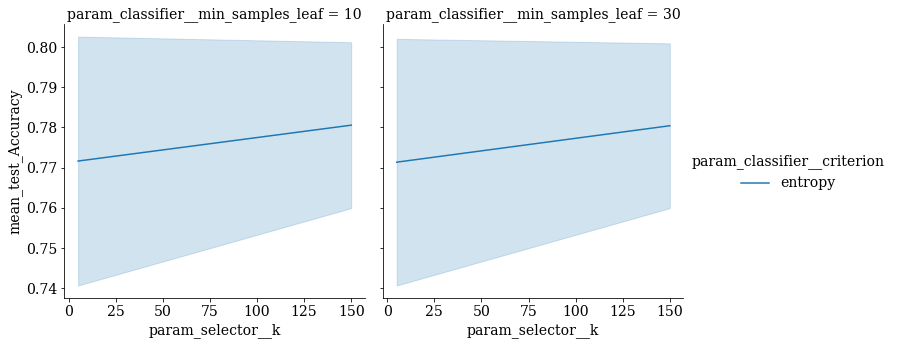

In [100]:
#plot the hyperperameters
sns_plot=sns.relplot(data=result_df,
	kind='line',
	x='param_selector__k',
	y='mean_test_Accuracy',
	hue='param_classifier__criterion',
	col='param_classifier__min_samples_leaf')

# 7.Evaluate the "best" models by confusion and fairness

In [25]:
#best chi2 params
best_chi2=DecisionTreeClassifier(criterion='entropy',max_depth=5, max_leaf_nodes=30, min_samples_leaf=30, min_samples_split=10)
chi_fs=SelectKBest(k=150,score_func=chi2)
chi_pipe=Pipeline([('selector',chi_fs),('classifier',best_chi2)])
chi_pipe.fit(X_train,y_train)
print('Best chi2')
print('Train',chi_pipe.score(X_train,y_train))
print('Test',chi_pipe.score(X_test,y_test))
chi_ypred=chi_pipe.predict(X_test)
print(classification_report(y_test, chi_ypred))

Best chi2
Train 0.8123518750871322
Test 0.8084552845528455
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      1673
           1       0.86      0.70      0.77      1402

    accuracy                           0.81      3075
   macro avg       0.82      0.80      0.80      3075
weighted avg       0.82      0.81      0.81      3075



In [26]:
#best mutual info params
best_mi=DecisionTreeClassifier(criterion='entropy',max_depth=5, max_leaf_nodes=30, min_samples_leaf=10, min_samples_split=10)
mi_fs=SelectKBest(k=5,score_func=mutual_info_classif)
mi_pipe=Pipeline([('selector',mi_fs),('classifier',best_mi)])
mi_pipe.fit(X_train,y_train)
print('BestMI')
print('Train',mi_pipe.score(X_train,y_train))
print('Test',mi_pipe.score(X_test,y_test))
chi_ypred=mi_pipe.predict(X_test)
print(classification_report(y_test, chi_ypred))

BestMI
Train 0.8088665830196571
Test 0.8123577235772358
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1673
           1       0.85      0.71      0.78      1402

    accuracy                           0.81      3075
   macro avg       0.82      0.80      0.81      3075
weighted avg       0.82      0.81      0.81      3075



# 8.Plot the Decision Tree produced by the models

The US Prisoners library retains feature names after one hot encoding and scaling. 

This means decision trees can be inspected. 

Branches to the right indicate true, whereas branches to the left indicate false

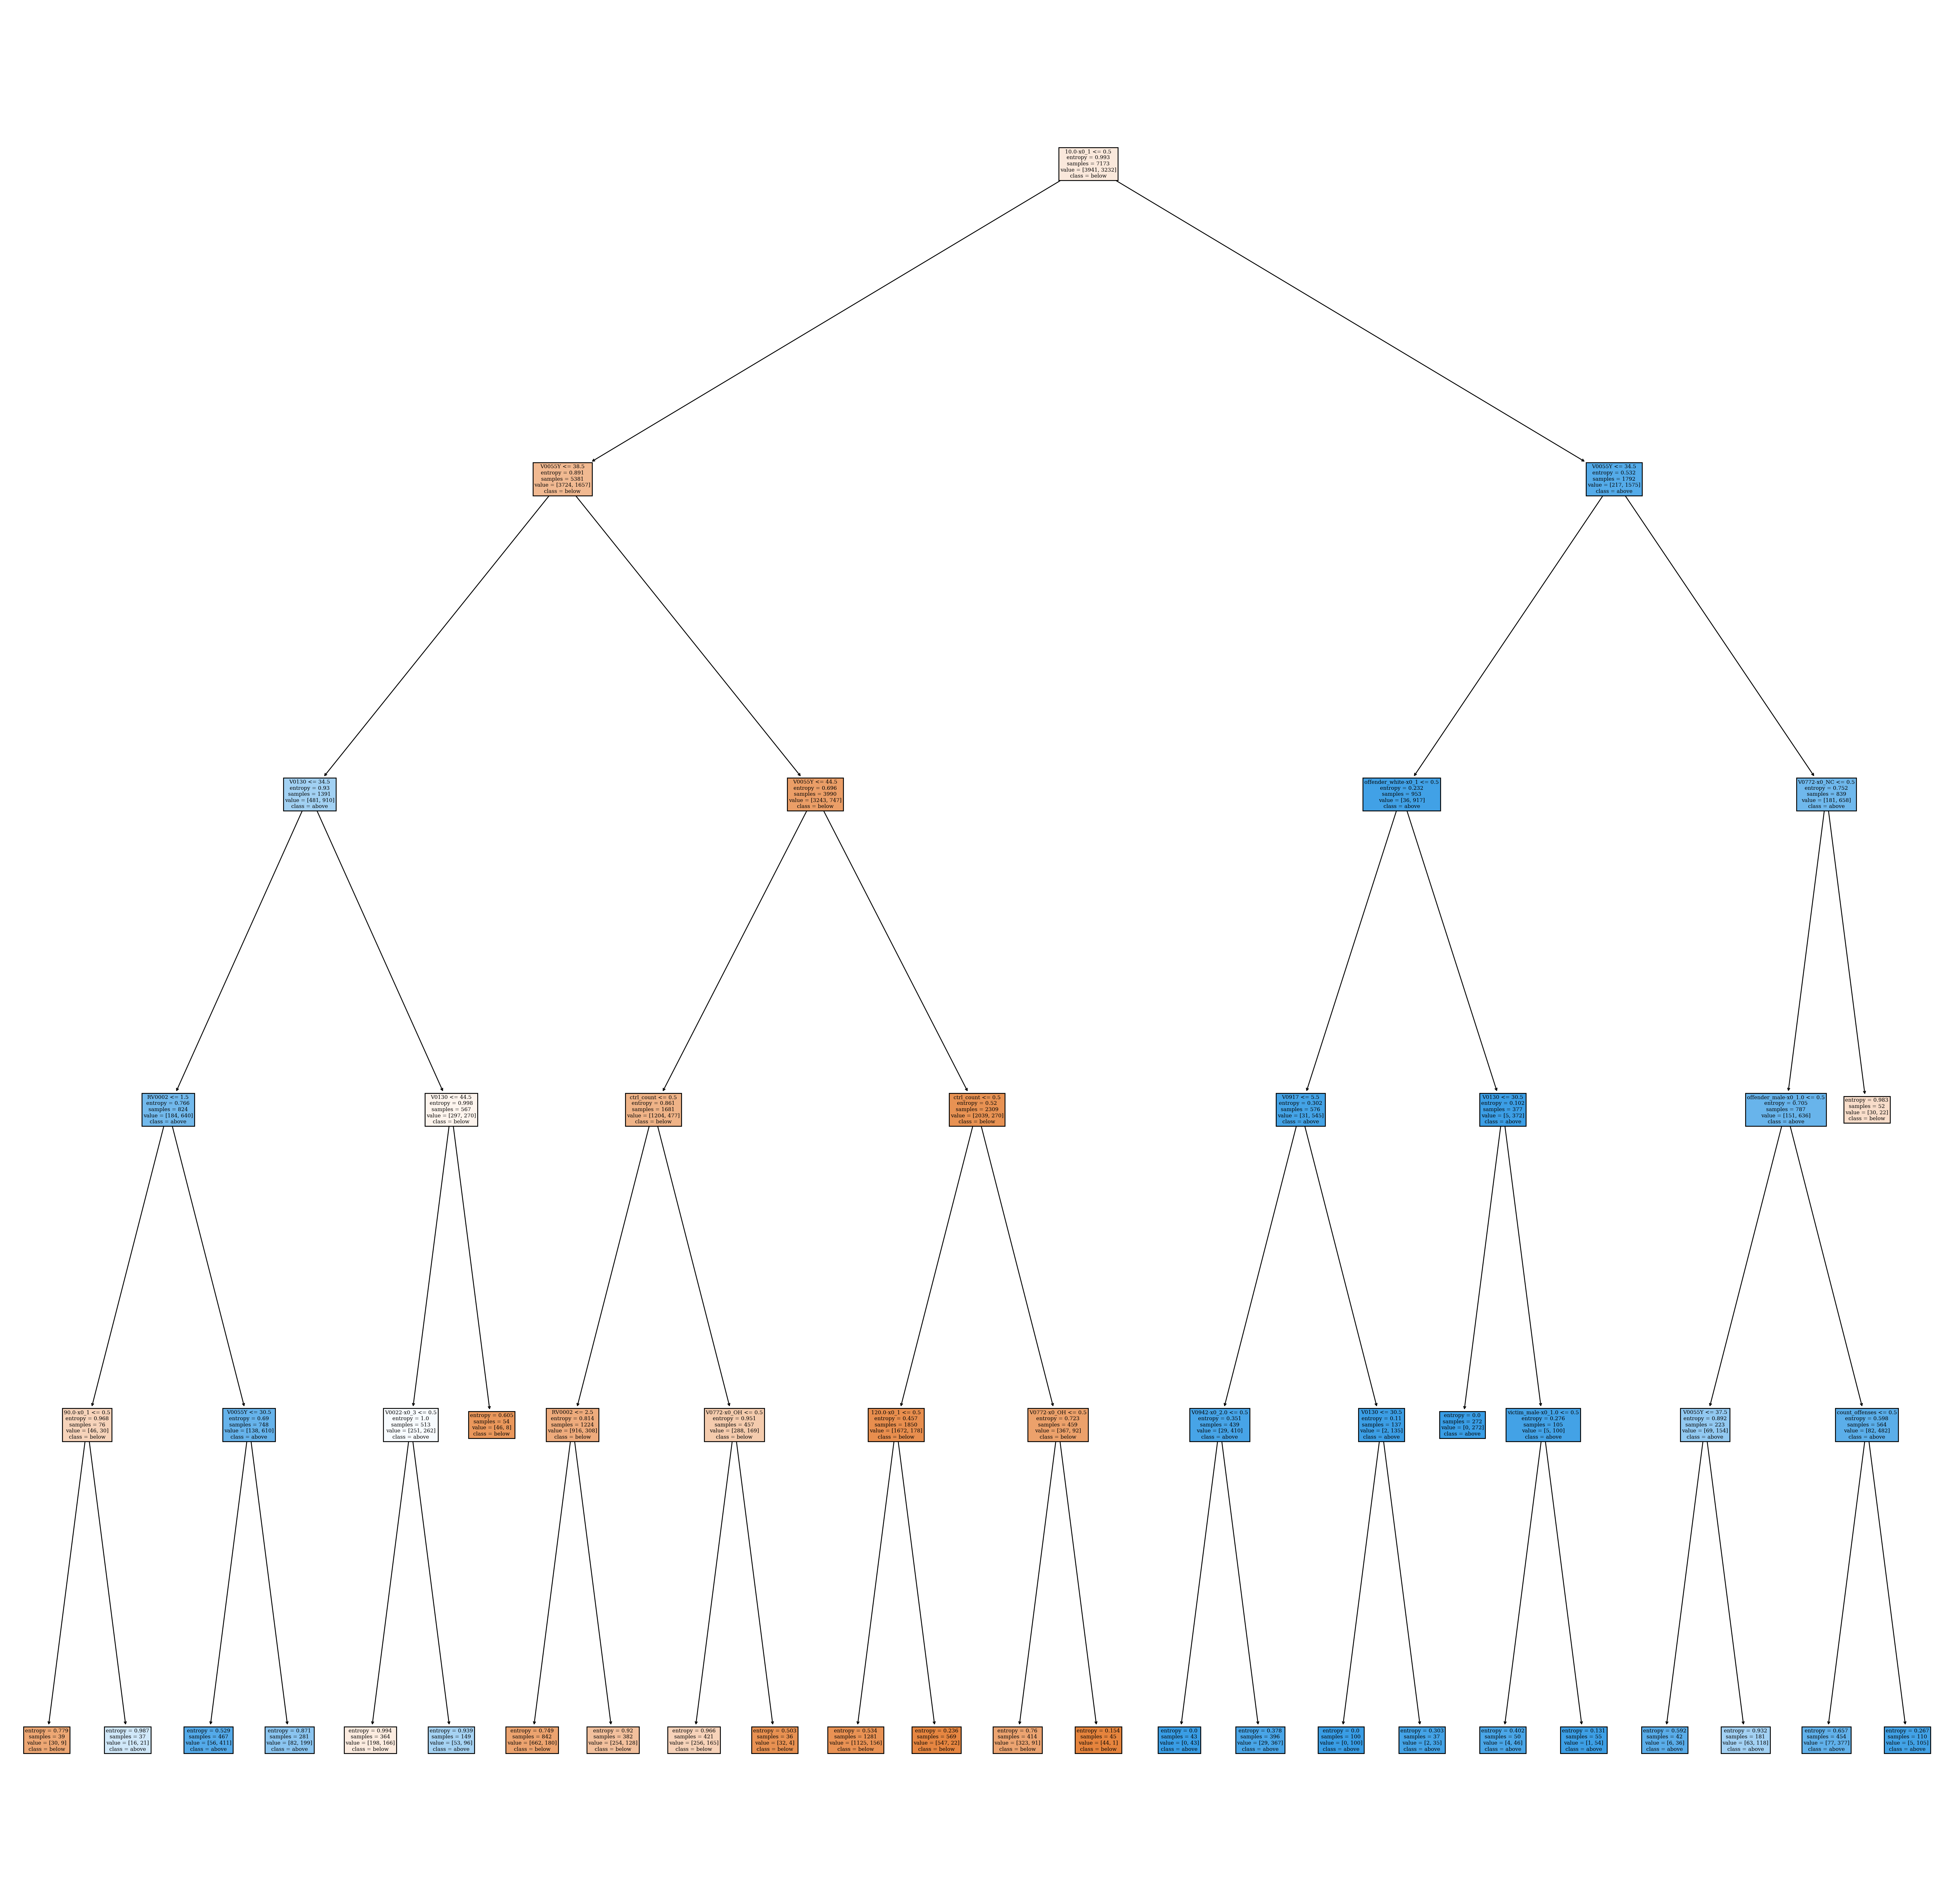

In [27]:
#reimport mpl as sns being used earlier in notebook sometimes causes an issue
from matplotlib import pyplot as plt
chi_fs.fit(X_train,y_train)
cols = chi_fs.get_support(indices=True)
X_train_new = X_train.iloc[:,cols]
X_test_new = X_test.iloc[:,cols]
best_chi2.fit(X_train_new,y_train)
plt.figure(dpi=200, figsize=(40,40))
tree.plot_tree(best_chi2, filled=True, feature_names=X_train_new.columns,class_names=['below','above'])
plt.savefig('best_chi2_dtree')
plt.show()

In [ ]:

mi_fs.fit(X_train,y_train)
cols = mi_fs.get_support(indices=True)
X_train_new = X_train.iloc[:,cols]
X_test_new = X_test.iloc[:,cols]
best_minfo.fit(X_train_new,y_train)
plt.figure(dpi=200, figsize=(40,40))
tree.plot_tree(best_minfo, filled=True, feature_names=X_train_new.columns,class_names=['below','above'])
plt.savefig('best_minfo_dtree')
plt.show()

# 9.More Complex Models

In [28]:
#LDA based on perams found through automl
#all features
LDA=LinearDiscriminantAnalysis(shrinkage=0.021126947, solver='lsqr',tol=3.7)
LDA.fit(X_train,y_train)
print(LDA.score(X_train,y_train))
print(LDA.score(X_test,y_test))

0.807472466192667
0.7973983739837398


# 10.Load auto sklearn

In [30]:
!sudo apt-get install build-essential swig
!pip install auto-sklearn
#from autosklearn.classification import AutoSklearnClassifier
import autosklearn.pipeline.components.data_preprocessing
from autosklearn.pipeline.components.base import AutoSklearnPreprocessingAlgorithm
from autosklearn.pipeline.constants import SPARSE, DENSE, UNSIGNED_DATA, INPUT
from ConfigSpace.configuration_space import ConfigurationSpace

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
swig is already the newest version (3.0.12-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:

from autosklearn.classification import AutoSklearnClassifier

# 11.Create a DENSE version of the Inmates with Violent Crimes dataset using the US Prisoners Package

In [31]:
#create a dense version of the dataset to pass to autosklearn by setting encoding and scale to 0
th=25
automl_violent_subset=prep.prep(subset, enc=0, scale=0, impute=1, years='scale', th=th,inc_max_range=1,low_freq_code_counts=0)
#drop the target column
target=f'sentence_above_{th}yrs'
X=automl_violent_subset.drop(labels=target,axis=1)
#this column has a bug in it 
X.drop('pp_low_freq_codes_sum',axis=1,inplace=True)
X.columns = X.columns.astype(str)
y=copy.deepcopy(automl_violent_subset[target])
X['V0772']=X['V0772'].astype('category')
X['ctrl_count']=X['ctrl_count'].astype('int32')
X['ctrl_apply']=X['ctrl_apply'].astype('category')

#split into test and training data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=25)

Dataset processor object initialised
type is <class 'src.dataset_processor.dataset_processor'>
type is <class 'pandas.core.frame.DataFrame'>



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0    5614
1    4634
Name: sentence_above_25yrs, dtype: int64
Sentence threshold variable is sentence_above_25yrs and distribution is
0    5614
1    4634
Name: sentence_above_25yrs, dtype: int64
Sentence calculated
Setting control apply type
Setting offense code counts
Collapsing offense lists
Setting ctrl lookup 1
Setting control lookup1
Looking up controlling offense
Finding further controlling offenses
Setting parole and probation violation
parole value counts
0.0    8811
1.0    1409
2.0      28
Name: parole, dtype: int64
probation value counts
0.0    9336
1.0     879
2.0      33
Name: probation, dtype: int64
Searching for violent type
Getting parole and probation offense counts
[]
Dropping low frequency offense codes
Offenses set
Victim white value counts
1    5704
0    4351
2     193
Name: victim_white, dtype: int64


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Offender race value counts
0    5869
1    4379
Name: offender_white, dtype: int64
Victim male value counts
0.0    5512
1.0    4736
Name: victim_male, dtype: int64
Offender male value counts
 1.0    8341
 0.0    1846
-8.0      61
Name: offender_male, dtype: int64
Protected attributes set
Victim injuries set
Victim relationship set
Victim age set
Starting encoding and scaling
Encoding/Scaling V0022
Encoding/Scaling V0023
Encoding/Scaling V0055Y
Encoding/Scaling V0063
Encoding/Scaling V0130
Encoding/Scaling V0314
Encoding/Scaling V0315
Encoding/Scaling V0450
Encoding/Scaling V0451
Encoding/Scaling V0452
Encoding/Scaling V0453
Encoding/Scaling V0458
Encoding/Scaling V0459
Encoding/Scaling V0460
Encoding/Scaling V0461
Encoding/Scaling V0462
Encoding/Scaling V0463
Encoding/Scaling V0478
Encoding/Scaling V0479
Encoding/Scaling V0480
Encoding/Scaling V0772
Encoding/Scaling V0774
Encoding/Scaling V0776
Encoding/Scaling V0778
Encoding/Scaling V0779
Encoding/Scaling V0780
Encoding/Scaling V0781
E

# 12.Initialise and fit an auto sklearn instance

The below cell shows how to intitialise and train an auto sklearn model. 
The time left for the task should be updated to 11 hours  (Colab Pro + times out after 12)
The training time set to 5 minutes/300 seconds as a dummy run

In [ ]:
#set n jobs to number of cores on machine
#set time left should be set to 216000 seconds/ 11 hours- the below is just a test run
#auto sklearn docs reccommend 24 hours, but colab times out
#ensemble size set to 1 to reduce search complexity
#may need to reload scikit learn 
auto_model = AutoSklearnClassifier(n_jobs=8,time_left_for_this_task=300, ensemble_size=1,
    initial_configurations_via_metalearning=1)
auto_model.fit(X_train, y_train)

In [ ]:
# evaluate best model
y_hat = auto_model.predict(X_test)
acc = accuracy_score(y_test, y_hat)
print("Accuracy: %.3f" % acc)

In [37]:
auto_model.show_models()

{2: {'model_id': 2,
  'rank': 1,
  'cost': 0.18366592756836664,
  'ensemble_weight': 1.0,
  'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7fe30375e2d0>,
  'balancing': Balancing(random_state=1),
  'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x7fe303777950>,
  'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice at 0x7fe303284cd0>,
  'sklearn_classifier': RandomForestClassifier(max_features=12, n_estimators=512, n_jobs=1,
                         random_state=1, warm_start=True)}}

In [38]:
print(auto_model.sprint_statistics())

auto-sklearn results:
  Dataset name: 1c091a86-283c-11ed-803d-0242ac1c0002
  Metric: accuracy
  Best validation score: 0.816334
  Number of target algorithm runs: 45
  Number of successful target algorithm runs: 40
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 3
  Number of target algorithms that exceeded the memory limit: 2



In [43]:
#the runtime will stop once the session becomes inactive or once 12 hours is up
# so it's a good idea to save the results to a drive locaiton outside of current runtime
cv_results=auto_model.cv_results_
cv_results_df=pd.DataFrame(cv_results)
cv_results_df.to_csv("/content/drive/My Drive/auto_model_results.pkl")